In [69]:
from lib.ekyn import *
from torch.utils.data import DataLoader,ConcatDataset,TensorDataset
from lib.datasets import EpochedDataset
from sklearn.model_selection import train_test_split
import torch
from lib.models import RegNetX
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.nn.functional import relu

CONFIG = {
    'BATCH_SIZE':256,
    'WINDOW_SIZE':5000,
    'LEARNING_RATE':3e-4,
    'TEST_SIZE':.25,
    'DEVICE':'cuda',
    'DEPTHI':[4,4,1,1],
    'WIDTHI':[4,8,16,32],
    'STEM_KERNEL_SIZE':7
}

class EpochedDataset(torch.utils.data.Dataset):
    """
    Dataset for training w1 resnets with ekyn data
    """
    def __init__(self,dataset='ekyn',id='A1-1',condition='Vehicle',robust=True):
        if dataset == 'ekyn':
            if robust:
                X,y = load_ekyn_pt_robust(id=id,condition=condition)
            else:
                X,y = load_ekyn_pt(id=id,condition=condition)
        elif dataset == 'snezana_mice':
            if robust:
                X,y = load_snezana_mice_pt_robust(id=id)
            else:
                X,y = load_snezana_mice_pt(id=id)
        self.X = X
        self.y = y
        self.id = id

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx:idx+1],self.y[idx])

snezana_mice_ids = get_snezana_mice_ids()
ekyn_ids = get_ekyn_ids()

trainloader = DataLoader(
    ConcatDataset(
        [
            EpochedDataset(
                dataset='ekyn',id=id,condition='Vehicle'
                ) for id in ekyn_ids[:4]
        ] + 
        [
            EpochedDataset(
                dataset='snezana_mice',id=id
                ) for id in snezana_mice_ids[:4]
        ]
        ),batch_size=CONFIG['BATCH_SIZE'],shuffle=True
    )
# devloader = DataLoader(
#     ConcatDataset(
#         [
#             EpochedDataset(
#                 dataset='ekyn',id=id,condition='Vehicle'
#                 ) for id in ekyn_ids[4:5]
#         ] + 
#         [
#             EpochedDataset(
#                 dataset='snezana_mice',id=id
#                 ) for id in snezana_mice_ids[4:5]
#         ]
#         ),batch_size=CONFIG['BATCH_SIZE'],shuffle=True
#     )
ekynloader = DataLoader(
    ConcatDataset(
        [
            EpochedDataset(
                dataset='ekyn',id=id,condition='Vehicle'
                ) for id in ekyn_ids[4:8]
        ]
        ),batch_size=CONFIG['BATCH_SIZE'],shuffle=True
    )
miceloader = DataLoader(
    ConcatDataset(
        [
            EpochedDataset(
                dataset='snezana_mice',id=id
                ) for id in snezana_mice_ids[4:8]
        ]
        ),batch_size=CONFIG['BATCH_SIZE'],shuffle=True
    )

In [70]:
from lib.models import YBlock,RegNetY
import math
model = RegNetY(depth=CONFIG['DEPTHI'],width=CONFIG['WIDTHI'],stem_kernel_size=CONFIG['STEM_KERNEL_SIZE'])
criterion = torch.nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716]))
optimizer = torch.optim.AdamW(model.parameters(),lr=CONFIG['LEARNING_RATE'])
model.to(CONFIG['DEVICE']);
criterion.to(CONFIG['DEVICE']);
print(sum([p.flatten().size()[0] for p in list(model.parameters())]))

3639


In [71]:
lossi = []
trainlossi = []
trainf1 = []
devlossi = []
devf1 = []
ekynlossi = []
ekynf1 = []
micelossi = []
micef1 = []
model.train()
from lib.utils import training_loop,development_loop
for i in tqdm(range(1000)):
    loss,f1 = training_loop(model=model,trainloader=trainloader,criterion=criterion,optimizer=optimizer,device=CONFIG['DEVICE'])
    trainlossi.append(loss)
    trainf1.append(f1)

    # loss,f1 = development_loop(model=model,devloader=devloader,criterion=criterion,device=CONFIG['DEVICE'])
    # devlossi.append(loss)
    # devf1.append(f1)

    loss,f1 = development_loop(model=model,devloader=ekynloader,criterion=criterion,device=CONFIG['DEVICE'])
    ekynlossi.append(loss)
    ekynf1.append(f1)

    loss,f1 = development_loop(model=model,devloader=miceloader,criterion=criterion,device=CONFIG['DEVICE'])
    micelossi.append(loss)
    micef1.append(f1)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
    ax[0].plot(trainlossi)
    # ax[0].plot(devlossi)
    ax[0].plot(ekynlossi)
    ax[0].plot(micelossi)
    ax[1].plot(trainf1)
    # ax[1].plot(devf1)
    ax[1].plot(ekynf1)
    ax[1].plot(micef1)
    plt.savefig('loss.jpg')
    plt.close()

 23%|██▎       | 227/1000 [31:15<1:50:49,  8.60s/it]

100%|██████████| 608/608 [00:02<00:00, 248.15it/s]


              precision    recall  f1-score   support

         0.0       0.72      0.28      0.40      6479
         1.0       0.94      0.93      0.93     59363
         2.0       0.91      0.95      0.93     89678

    accuracy                           0.92    155520
   macro avg       0.85      0.72      0.76    155520
weighted avg       0.91      0.92      0.91    155520

0.2228319067753067


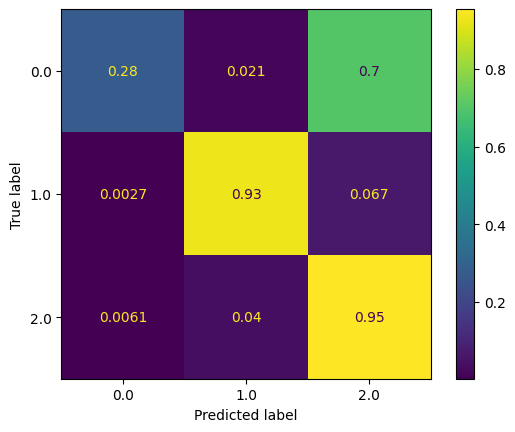

In [52]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

100%|██████████| 169/169 [00:00<00:00, 231.73it/s]


              precision    recall  f1-score   support

         0.0       0.59      0.29      0.39      2099
         1.0       0.92      0.96      0.94     18599
         2.0       0.91      0.92      0.91     22502

    accuracy                           0.91     43200
   macro avg       0.81      0.72      0.75     43200
weighted avg       0.90      0.91      0.90     43200

0.247026745472434


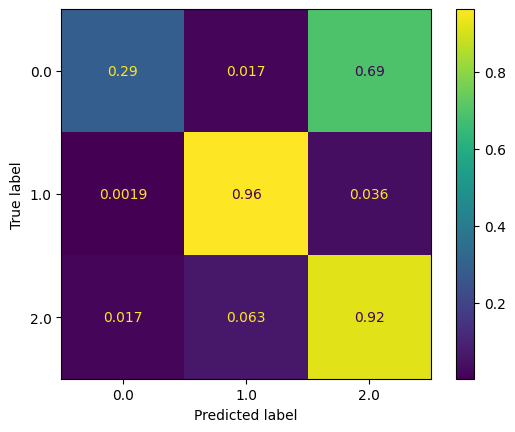

In [53]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

100%|██████████| 169/169 [00:00<00:00, 244.62it/s]


              precision    recall  f1-score   support

         0.0       0.59      0.29      0.39      2099
         1.0       0.92      0.96      0.94     18599
         2.0       0.91      0.92      0.91     22502

    accuracy                           0.91     43200
   macro avg       0.81      0.72      0.75     43200
weighted avg       0.90      0.91      0.90     43200

0.24705574304394468


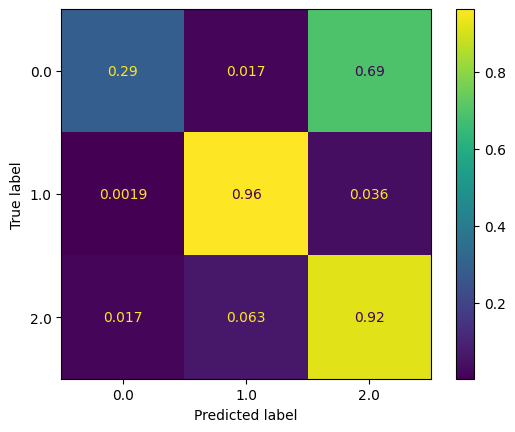

In [62]:
testloader = DataLoader(
    ConcatDataset(
        [
            EpochedDataset(
                dataset='ekyn',id=id,condition='Vehicle'
                ) for id in ekyn_ids[4:5]
        ] + 
        [
            EpochedDataset(
                dataset='snezana_mice',id=id
                ) for id in snezana_mice_ids[4:5]
        ]
        ),batch_size=CONFIG['BATCH_SIZE'],shuffle=True
    )
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

In [54]:
import pandas as pd
df = pd.DataFrame()

for id in ekyn_ids[4:5]:
    testloader = DataLoader(EpochedDataset(dataset='ekyn',id=id,condition='Vehicle'),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)
    loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
    report['id'] = id
    df = pd.concat([df,pd.Series(report)],axis=1)
for id in snezana_mice_ids[4:5]:
    testloader = DataLoader(EpochedDataset(dataset='snezana_mice',id=id),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)
    loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
    report['id'] = id
    df = pd.concat([df,pd.Series(report)],axis=1)

100%|██████████| 135/135 [00:00<00:00, 258.79it/s]


In [60]:
df

,0,0
precision,0.696862,0.833935
recall,0.660574,0.742733
f1,0.66713,0.770407
id,B3-1,21-HET-13
